# Neural Network Model for Good Seed Supermarket

The supermarket chain Good Seed would like to explore whether Data Science can help them adhere to alcohol laws by making sure they do not sell alcohol to people underage. I am asked to conduct that evaluation and here are some guideline:

- The shops are equipped with cameras in the checkout area which are triggered when a person is buying alcohol
- Computer vision methods can be used to determine age of a person from a photo
- The task then is to build and evaluate a model for verifying people's age

## Initialization

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find

- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [ ]:
labels = pd.read_csv('/datasets/faces/labels.csv')
labels.sample(5)

,file_name,real_age
204,000204.jpg,16
106,000106.jpg,45
2238,002238.jpg,26
3268,003268.jpg,22
2040,002040.jpg,20


In [ ]:
labels.real_age.max()

100

In [ ]:
labels.real_age.min()

1

In [ ]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [ ]:
# check for duplicate value
labels.duplicated().sum()

0

## EDA

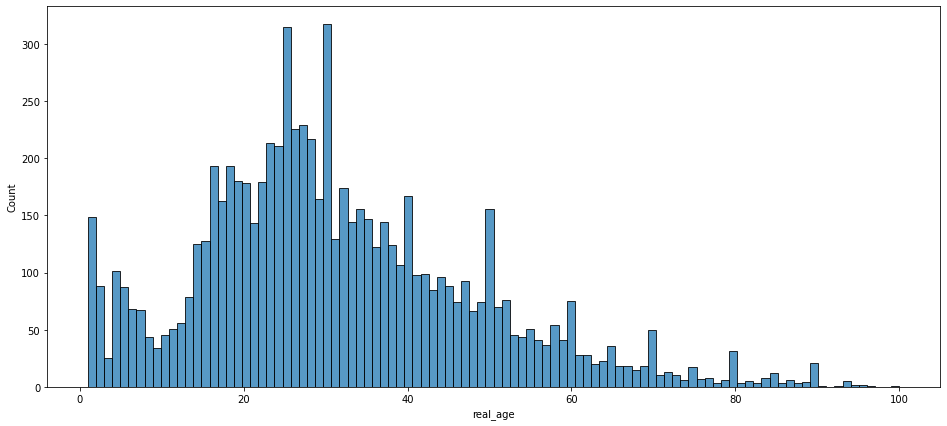

In [ ]:
#Plotting an histogram of real_age column to understand age distribution in the df.
plt.figure(figsize=(16,7))
sns.histplot(labels['real_age'], bins = 100)
plt.show()

In [ ]:
datagen = ImageDataGenerator(rescale=1./255)

data_flow = datagen.flow_from_dataframe(
    dataframe = labels,
    directory = '/datasets/faces/final_files/',
    x_col = 'file_name',
    y_col = 'real_age',
    target_size = (224,244),
    batch_size = 32,
    class_mode = 'raw',
    seed = 12345)

Found 7591 validated image filenames.


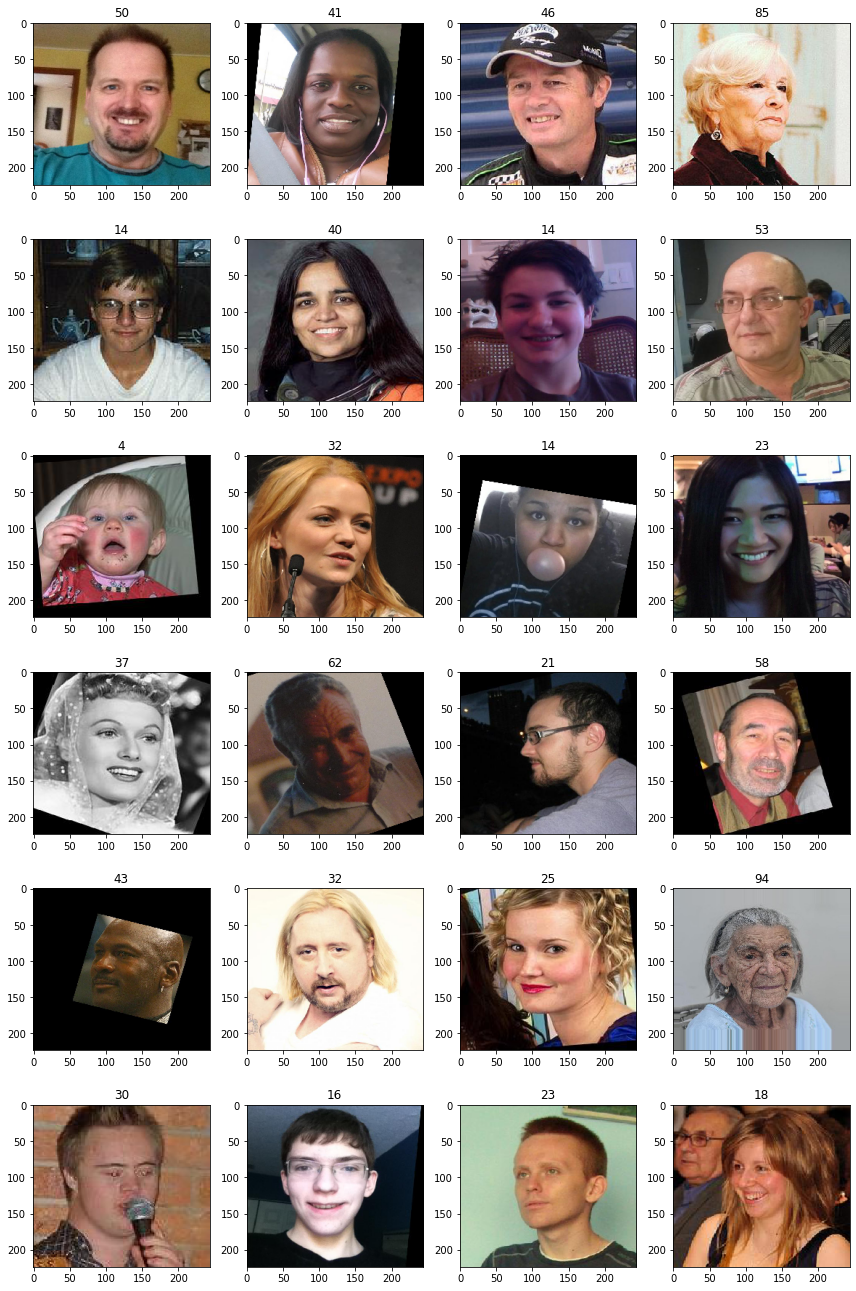

In [ ]:
def show_images(batch, predictions=None):
    fig = plt.figure(figsize=(12,24))

    for i in range(24):
        fig.add_subplot(8,4, i+1)
        plt.imshow(batch[0][i])
        title = batch[1][i]
        if predictions is not None:
            title = f'gt: {title}, prediction: {round(predictions[i])}'
        plt.title(title)

    fig.tight_layout()

show_images(next(data_flow))

### Findings

1. This is a regression task.
2. We need the final layer with only one neuron cause it has to return one single value as output. I am going to add it to the backbone of ResNet50 by adding a Dense layer.
3. Since we don't need negative values to be computed I am going to use 'ReLu' activation to transform those values in zeros.
4. The suitable loss function is 'MSE' and the metric we are going to use is 'MAE' it should be less then 8.

## Modeling

In [ ]:
def load_train(path):

    """
    This code loads the train part of dataset from path
    """

    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split = .25,
        rescale = 1./255)

    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col = 'file_name',
        y_col = 'real_age',
        target_size = (224,244),
        batch_size = 16,
        class_mode = 'raw',
        subset='training',
        seed = 12345)

    return train_gen_flow

In [ ]:
def load_test(path):

    """
    This code loads the validation/test part of dataset from path
    """

    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split = .25,
        rescale = 1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col = 'file_name',
        y_col = 'real_age',
        target_size = (224,244),
        batch_size = 16,
        class_mode = 'raw',
        subset='validation',
        seed = 12345)

    return test_gen_flow

In [ ]:
def create_model(input_shape):

    """
    This code defines the model
    """
    backbone = ResNet50(weights='imagenet',
                       input_shape=input_shape,
                       include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.00025)
    model.compile(optimizer=optimizer, loss = 'mse', metrics=['mae'])

    return model

In [ ]:
def train_model(model, train_data, test_data, batch_size=None, epochs=29,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """

    if step_per_epoch is None:
        step_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
             epochs = epochs,
             validation_data=test_data,
             batch_size=batch_size,
             steps_per_epoch=steps_per_epoch,
             validation_steps = validation_steps,
             verbose=1)

    return model

## Prepare the Script to Run on the GPU Platform

In [ ]:
# prepare the script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:

    f.write(init_str)
    f.write('\n\n')

    for fn_name in [load_train, load_test, create_model, train_model]:

        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Train for 356 steps, validate for 119 steps
Epoch 1/29

2023-05-18 07:01:34.781238: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-05-18 07:01:36.813773: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7

356/356 [==============================] - 76s 214ms/step - loss: 184.1125 - mae: 10.1810 - val_loss: 370.6949 - val_mae: 14.3691

Epoch 2/29

356/356 [==============================] - 39s 110ms/step - loss: 92.7678 - mae: 7.3654 - val_loss: 271.2547 - val_mae: 12.2084

Epoch 3/29

356/356 [==============================] - 39s 110ms/step - loss: 59.8143 - mae: 5.9141 - val_loss: 91.7697 - val_mae: 7.3127

Epoch 4/29

356/356 [==============================] - 39s 110ms/step - loss: 34.7238 - mae: 4.5569 - val_loss: 90.5750 - val_mae: 7.1617

Epoch 5/29

356/356 [==============================] - 40s 111ms/step - loss: 24.4907 - mae: 3.8114 - val_loss: 80.9124 - val_mae: 6.7755

Epoch 6/29

356/356 [==============================] - 39s 111ms/step - loss: 18.8870 - mae: 3.3420 - val_loss: 68.7492 - val_mae: 6.2570

Epoch 7/29

356/356 [==============================] - 39s 110ms/step - loss: 15.3117 - mae: 3.0284 - val_loss: 81.4717 - val_mae: 6.9904

Epoch 8/29

356/356 [==============================] - 39s 111ms/step - loss: 14.8275 - mae: 2.9392 - val_loss: 116.6217 - val_mae: 7.9857

Epoch 9/29

356/356 [==============================] - 39s 110ms/step - loss: 14.8049 - mae: 2.9366 - val_loss: 69.9172 - val_mae: 6.2729

Epoch 10/29

356/356 [==============================] - 39s 110ms/step - loss: 12.9823 - mae: 2.7517 - val_loss: 76.1894 - val_mae: 6.5255

Epoch 11/29

356/356 [==============================] - 39s 110ms/step - loss: 13.0732 - mae: 2.7443 - val_loss: 73.0948 - val_mae: 6.4675

Epoch 12/29

356/356 [==============================] - 39s 110ms/step - loss: 12.0810 - mae: 2.6434 - val_loss: 71.0998 - val_mae: 6.3653

Epoch 13/29

356/356 [==============================] - 39s 110ms/step - loss: 11.2001 - mae: 2.5335 - val_loss: 102.0196 - val_mae: 7.9969

Epoch 14/29

356/356 [==============================] - 39s 111ms/step - loss: 10.7919 - mae: 2.5407 - val_loss: 67.5465 - val_mae: 6.1424

Epoch 15/29

356/356 [==============================] - 39s 110ms/step - loss: 12.2469 - mae: 2.6813 - val_loss: 77.5296 - val_mae: 6.6698

Epoch 16/29

356/356 [==============================] - 39s 111ms/step - loss: 12.6091 - mae: 2.7027 - val_loss: 70.8442 - val_mae: 6.3156

Epoch 17/29

356/356 [==============================] - 39s 110ms/step - loss: 11.6851 - mae: 2.5783 - val_loss: 82.2087 - val_mae: 6.9261

Epoch 18/29

356/356 [==============================] - 39s 111ms/step - loss: 10.5711 - mae: 2.4473 - val_loss: 71.1096 - val_mae: 6.4040

Epoch 19/29

356/356 [==============================] - 39s 110ms/step - loss: 8.9010 - mae: 2.2545 - val_loss: 74.1662 - val_mae: 6.4116

Epoch 20/29

356/356 [==============================] - 39s 110ms/step - loss: 7.1042 - mae: 2.0055 - val_loss: 68.2408 - val_mae: 6.1958

Epoch 21/29

356/356 [==============================] - 39s 110ms/step - loss: 5.6716 - mae: 1.7994 - val_loss: 67.5673 - val_mae: 6.2974

Epoch 22/29

356/356 [==============================] - 39s 110ms/step - loss: 5.0674 - mae: 1.6954 - val_loss: 66.6505 - val_mae: 6.1745

Epoch 23/29

356/356 [==============================] - 39s 110ms/step - loss: 5.6313 - mae: 1.8138 - val_loss: 71.2257 - val_mae: 6.4761

Epoch 24/29

356/356 [==============================] - 39s 111ms/step - loss: 6.4872 - mae: 1.9461 - val_loss: 72.9387 - val_mae: 6.4347

Epoch 25/29

356/356 [==============================] - 39s 111ms/step - loss: 8.1688 - mae: 2.1754 - val_loss: 74.3096 - val_mae: 6.5365

Epoch 26/29

356/356 [==============================] - 39s 111ms/step - loss: 10.2948 - mae: 2.4544 - val_loss: 86.4567 - val_mae: 6.8647

Epoch 27/29


356/356 [==============================] - 40s 111ms/step - loss: 10.6688 - mae: 2.4755 - val_loss: 110.7793 - val_mae: 7.9179

Epoch 28/29

356/356 [==============================] - 40s 111ms/step - loss: 28.5214 - mae: 3.9344 - val_loss: 83.6676 - val_mae: 6.8672

Epoch 29/29

356/356 [==============================] - 39s 110ms/step - loss: 12.5058 - mae: 2.6250 - val_loss: 71.5800 - val_mae: 6.3524

WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to
  ['...']
119/119 - 10s - loss: 71.5800 - mae: 6.3524
Test MAE: 6.3524

## Conclusions

In this project, I trained a model to recognize the age of a person from photos. The model used was ResNet50, with 'relu' activation to transform negative values into 0, and an additional final layer with one neuron to produce a single output obtained through regression. The chosen loss function was 'mse' and the metric used was 'mae'. I did not use any type of augmentation when defining the training and testing sets. The lowest obtained MAE value was 1.6954.